In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras import metrics

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


c:\Users\Robbe Breens\anaconda3\envs\BP-TACO\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
batch_size = 4
img_height = 180
img_width = 180
data_dir = "../../../data/customdataset/"


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




Found 1856 files belonging to 2 classes.
Using 1485 files for training.
Found 1856 files belonging to 2 classes.
Using 371 files for validation.
['background', 'litter']


InvalidArgumentError: slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

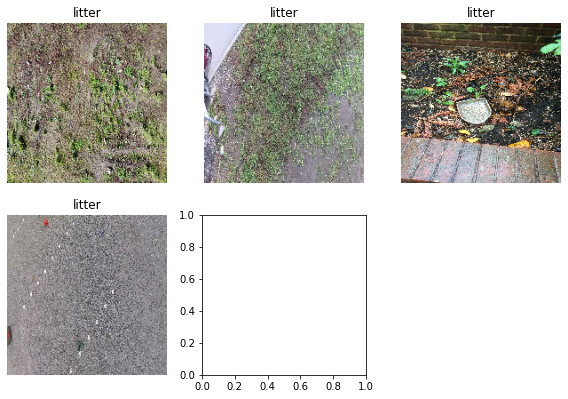

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [15]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, name="outputs")
])



In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [29]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/5
372/372 [==============================] - 6s 15ms/step - loss: 0.3832 - accuracy: 0.8397 - val_loss: 0.4380 - val_accuracy: 0.7925
Epoch 2/5
372/372 [==============================] - 6s 15ms/step - loss: 0.3676 - accuracy: 0.8525 - val_loss: 0.4036 - val_accuracy: 0.8086
Epoch 3/5
372/372 [==============================] - 5s 15ms/step - loss: 0.3581 - accuracy: 0.8444 - val_loss: 0.4033 - val_accuracy: 0.8167
Epoch 4/5
372/372 [==============================] - 6s 15ms/step - loss: 0.3520 - accuracy: 0.8485 - val_loss: 0.4378 - val_accuracy: 0.7951
Epoch 5/5
372/372 [==============================] - 6s 16ms/step - loss: 0.3620 - accuracy: 0.8444 - val_loss: 0.3740 - val_accuracy: 0.8194


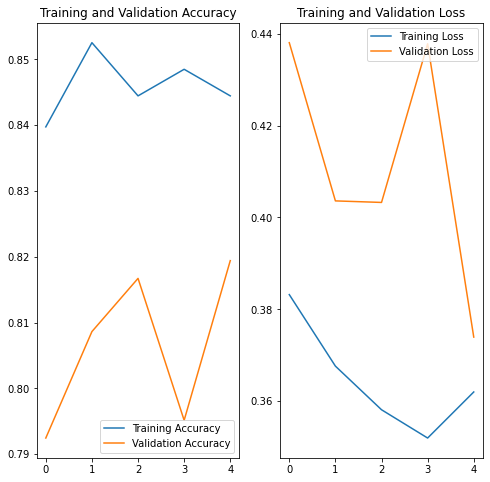

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()




In [28]:
sunflower_url = "https://farm66.staticflickr.com/65535/49578160248_afd98d6327_z.jpg"
sunflower_path = tf.keras.utils.get_file('litter', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to background with a 54.75 percent confidence.
